<a href="https://colab.research.google.com/github/JumanaSrour/Brain-Cancer-Classification/blob/main/Brain_Tumor_Classification_3Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [1]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 31.08 MiB/s, done.


## Import necessary Libraries 







In [2]:
import os
import random
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [3]:
# Create Directory for Training Data
os.mkdir("/content/Crop-Brain-MRI")
os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

In [4]:
# Create Directory for Testing Data
os.mkdir("/content/Test-Data")
os.mkdir("/content/Test-Data/glioma_tumor")
os.mkdir("/content/Test-Data/meningioma_tumor")
os.mkdir("/content/Test-Data/pituitary_tumor")

## Data Visualization

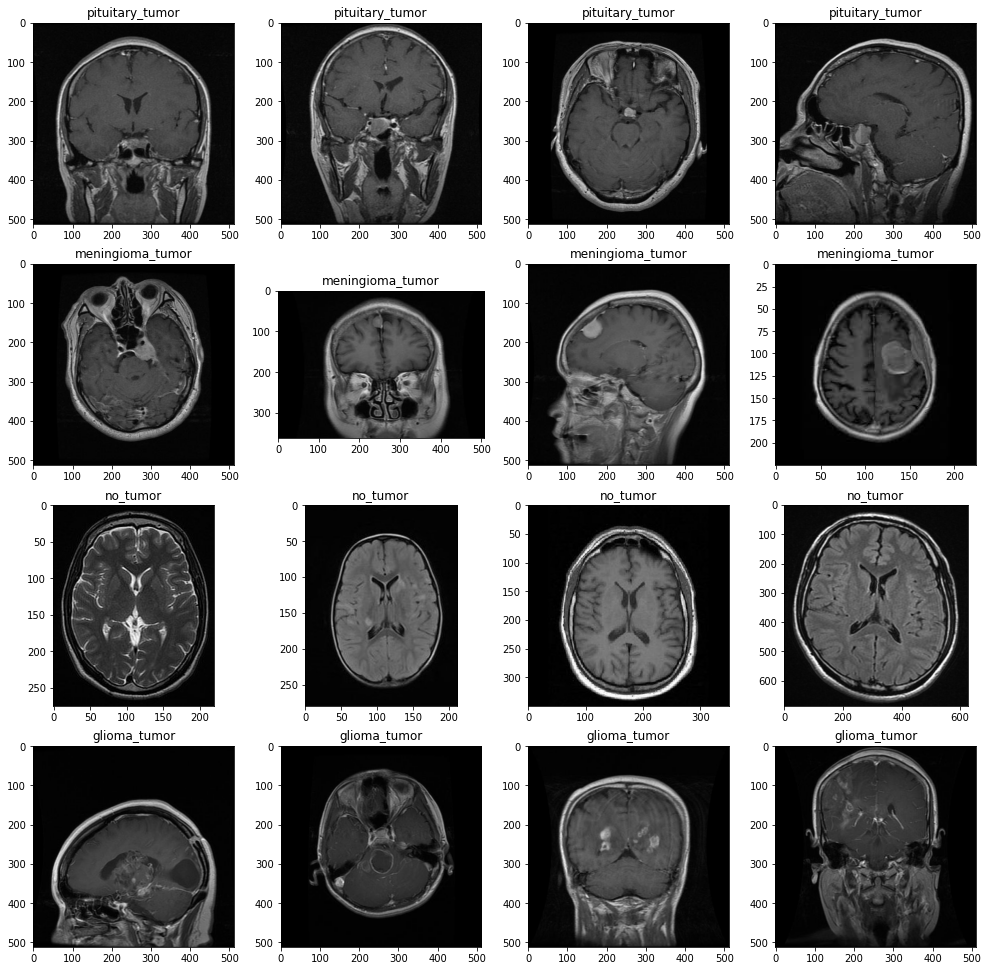

In [5]:
train_dir = "/content/Brain-Tumor-Classification-DataSet/Training/"
test_dir = "/content/Brain-Tumor-Classification-DataSet/Testing/"
classes = os.listdir("/content/Brain-Tumor-Classification-DataSet/Training")
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))


plt.figure(figsize=(17,17))
index = 0

for c in classes:
    random.shuffle(files_path_dict[c])
    path_list = files_path_dict[c][:5]

    for i in range(1, 5):
      index +=1
      plt.subplot(4, 4, index)
      plt.imshow(load_img(path_list[i]))
      plt.title(c)

## Create a Function to Crop Images

In [6]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


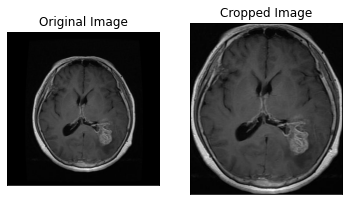

In [7]:
example_img = cv2.imread("/content/Brain-Tumor-Classification-DataSet/Training/glioma_tumor/gg (10).jpg")
crop_image = crop_image(example_img, plot=True)

## Saving The Cropped Images 

In [8]:
# Crop the Training Images and Save it to the Directory we previously cretaed
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  # img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/gli" + str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  # img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/men" + str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1  

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  # img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/pit" + str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1          

100%|██████████| 827/827 [00:04<00:00, 189.41it/s]


In [9]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
test_glioma = test_dir + "glioma_tumor"
test_meningioma = test_dir + "meningioma_tumor"
test_pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/glioma_tumor/glioma_tumor" + str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/meningioma_tumor/meningioma_tumor" + str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1  

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Data/pituitary_tumor/pituitary_tumor" + str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1     

100%|██████████| 74/74 [00:00<00:00, 118.62it/s]


In [10]:
! ls /content/Test-Data/

glioma_tumor  meningioma_tumor	pituitary_tumor


In [11]:
! ls /content/

Brain-Tumor-Classification-DataSet  Crop-Brain-MRI  sample_data  Test-Data


In [12]:
! ls /content/Crop-Brain-MRI/

glioma_tumor  meningioma_tumor	pituitary_tumor


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [13]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory(directory=r"/content/Crop-Brain-MRI/",
                                         target_size= (224,224),
                                         batch_size= 32,
                                         class_mode='categorical',
                                         subset= 'training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size= (224,224),
                                         batch_size= 32,
                                         class_mode='categorical',
                                         subset= 'validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                                         target_size= (224,224),                                     
                                         class_mode='categorical',
                                        )
print(train_data.image_shape)

Found 1981 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 289 images belonging to 3 classes.
(224, 224, 3)


In [14]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}


In [15]:
# View the augmented data.
sample_x, sample_y = next(train_data)

In [16]:
next(train_data)

(array([[[[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         [[ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          ...,
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ],
          [ 0.        ,  0.        ,  0.        ]],
 
         ...,
 
         [[ 

In [17]:
sample_x

array([[[[  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         ...,
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ]],

        [[  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         ...,
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ]],

        [[  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         ...,
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ],
         [  0.        ,   0.        ,   0.        ]],

In [18]:
sample_y

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

0
1
2
3
4
5


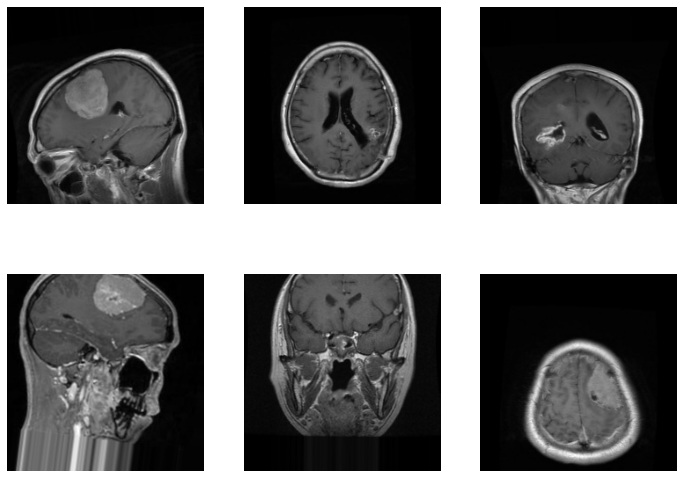

In [19]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12,9))
for i in range(6):
  print(i)
  plt.subplot(2, 3, i+1)
  samples = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(samples)
plt.show() 

## Build and Compile the Model 

In [20]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation="softmax")(model)
model = Model(effnet.input, model)

model.summary()

27033600/27018416 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D

In [21]:
opt =Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.Accuracy()])
checkpoint = ModelCheckpoint("model", save_weights_only=True, mode="auto", verbose=0)
earlystop = EarlyStopping(monitor="val_accuracy", patience=3, mode="auto", verbose=1)

## Model Training and Model Evaluation

In [22]:
# Train the model
history = model.fit(train_data, validation_data=valid_data, epochs=20,  verbose=2, callbacks=[checkpoint])


Epoch 1/20
62/62 - 130s - loss: 0.6384 - accuracy: 0.0000e+00 - val_loss: 0.7633 - val_accuracy: 0.0000e+00 - 130s/epoch - 2s/step
Epoch 2/20
62/62 - 78s - loss: 0.2833 - accuracy: 0.0000e+00 - val_loss: 0.3744 - val_accuracy: 0.0000e+00 - 78s/epoch - 1s/step
Epoch 3/20
62/62 - 77s - loss: 0.1873 - accuracy: 0.0000e+00 - val_loss: 0.2312 - val_accuracy: 0.0000e+00 - 77s/epoch - 1s/step
Epoch 4/20
62/62 - 76s - loss: 0.1284 - accuracy: 0.0000e+00 - val_loss: 0.1715 - val_accuracy: 0.0000e+00 - 76s/epoch - 1s/step
Epoch 5/20
62/62 - 76s - loss: 0.0855 - accuracy: 0.0000e+00 - val_loss: 0.1424 - val_accuracy: 0.0000e+00 - 76s/epoch - 1s/step
Epoch 6/20
62/62 - 75s - loss: 0.0748 - accuracy: 0.0000e+00 - val_loss: 0.1530 - val_accuracy: 0.0000e+00 - 75s/epoch - 1s/step
Epoch 7/20
62/62 - 79s - loss: 0.0637 - accuracy: 3.3653e-04 - val_loss: 0.1050 - val_accuracy: 0.0000e+00 - 79s/epoch - 1s/step
Epoch 8/20
62/62 - 76s - loss: 0.0410 - accuracy: 6.7306e-04 - val_loss: 0.0776 - val_accuracy:

In [23]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' +
                 str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for a in acc_list:
        plt.plot(epochs, history.history[a], 'b', label='Training accuracy (' +
                 str(str(format(history.history[a][-1],'.5f'))+')'))
    for a in val_acc_list:    
        plt.plot(epochs, history.history[a], 'g', label='Validation accuracy (' + str(str(format(history.history[a][-1],'.5f'))+')'))

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

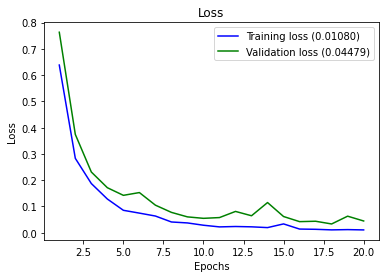

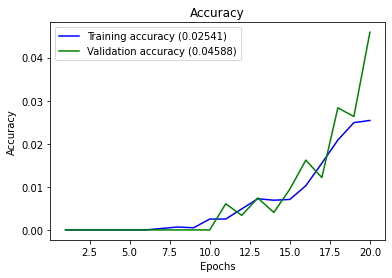

In [24]:
plot_history(history)

In [25]:
# Evaluate the model on Test Set
print('Test accuracy & loss:', model.evaluate(test_data))
print('Train accuracy & loss:', model.evaluate(train_data))

62/62 [==============================] - 29s 458ms/step - loss: 5.5227e-04 - accuracy: 0.0475


[0.0005522745195776224, 0.04745078086853027]

## Obtaining Predictions on Test Images

pituitary_tumor


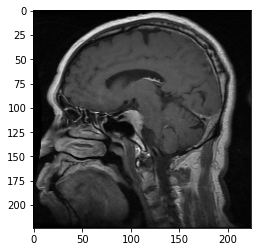

In [26]:
# Obtain Predictions on Test Images
class_dict = {0: "glioma_tumor", 1:"meningioma_tumor", 2:"pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Data/pituitary_tumor/pituitary_tumor11.jpg")
plt.imshow(np.asarray(test_img1))
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

In [27]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

[[13 65 22]
 [ 6 78 31]
 [11 47 16]]


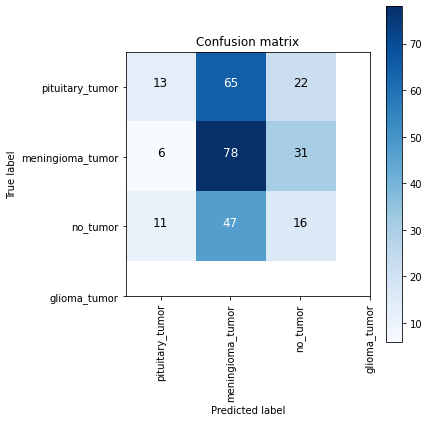

In [28]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
      
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.43      0.13      0.20       100
           1       0.41      0.68      0.51       115
           2       0.23      0.22      0.22        74

    accuracy                           0.37       289
   macro avg       0.36      0.34      0.31       289
weighted avg       0.37      0.37      0.33       289

